# Random Forest

* Suppose you ask a complex question to thousands of random people, then aggregate their answer. In many cases you will find the aggregated answer is better than an expert's answer. This is called the `wisdom-of -the -crowd`.
* Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. 
* A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.
* For example, you can train a group of Decision Tree classifer, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called `RandomForest`, and despite itsd simplicity, this is one of the most powerful Machine Learning algorithms available today.

#### What we are going to cover in this Notebook

* In this notebook we will discuss the most popular Ensemble methods, including `bagging`, `boosting`, `stacking` and a few others. We will also expore `Random Forests`.

# Voting Classifiers

* Suppose you have trained a few classifers, each one acheving about 80% accuracy, You may have a Logistic Regression classifer, an SVM classifer, a Random Forest classifer, a K-Nearest classifer, and perhaps a few more.
* A very simple way to create an even better classifer is to aggregate the predictions of each classifer and predict the class that gets the most votes. The majority-vote classifer is called a `hard-voting-classifer'.
* Somewhat surprisingly, this voting classifer often achives a higher accuracy than the best classifer in the ensemble. In fact, even if each classifer ia a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse.
> Ensemble methodfs work best when the predictors are as independent from one another as possible, One way to get diverse classifers is to train them using very different algorithms, This increases the chance that hey will make very different type of errors, improving the ensemble's accuracy.

#### The following code creates a nd trains a voting classifer in Scikit-Learn, composed of three diverse classifers (the training set is the moon dataset)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [32]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

In [26]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=None)

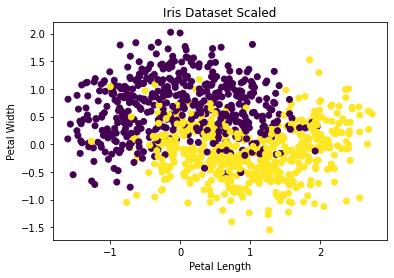

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X[:,0], X[:,1], c=y);
plt.title("Iris Dataset Scaled")
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
voting_clf = VotingClassifier(
    estimators = [("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting = "soft"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

##### Let's look at each classifier's accuracy on the test set.

In [30]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
RandomForestClassifier 0.855
SVC 0.905
VotingClassifier 0.885


There you have it! The voting classifier slightly outperforms all the individual classifers.

- If all classifier are able to estimate class probabilities (i.e, they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged overall the individual classifier. This is called `soft-voting`.

In [34]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
RandomForestClassifier 0.85
SVC 0.905
VotingClassifier 0.895


# Baging and Pasting

* One way to get a diverse classifier is to use very different algorithms as just discussed.
* Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.
* When sampling is performed with replacement, this method is called `bagging`. (short fot bootstrap aggregating). When Sampling is perormed without replacement, it is called `pasting`.
* In other words both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.
* Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode (i.e, the most frequent prediction, just like a hard voting classifer) for classification, or the average for regresson. Each individual predictor has the higher bias than if it ere trained on the original training set, but aggregation reduces both bias and variaance.
* Generally, the net result is that the ensemble has a similar bias but a lower a lower variance than a single predictor trained on the original training set.
> Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such powerful methods: they scale very well.

In [46]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.905

**Note** : The Bagging classifer automatically performs soft voting instead of hard voting if the base classifer can estimate class probabilities (i.e, if it has a predict_proba() method), which is the case with Decision Tree.

# Out-of-Bag Evaluation

* With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.
* Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
* In scikit-learn, you can set oob_score=True when creating a BaggingClasifer to request an automatic oob evaluation after training. The following below code demonstrates this.

In [56]:
bag_clf_2 = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators = 500,
    n_jobs= -1,
    bootstrap = True,
    oob_score = True,
    random_state=42,
    max_samples=100
)
bag_clf_2.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

In [58]:
bag_clf_2.oob_score_

0.855

- According to this oob evaluation, this BaggingClassifer is likely to achive about 85% accuracy on the test set. Let's verify it.

In [57]:
y_pred = bag_clf_2.predict(X_test)
accuracy_score(y_test, y_pred)

0.905

In [59]:
bag_clf_2.oob_decision_function_

array([[0.33333333, 0.66666667],
       [0.49184149, 0.50815851],
       [0.99321267, 0.00678733],
       ...,
       [0.00456621, 0.99543379],
       [0.46681416, 0.53318584],
       [0.19413093, 0.80586907]])

# Random Forest

* As we have discussed, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or some time the pasting method), typically with max_samples set to the size of the training set. Instead of building a BaggingClassifer and passing it a DecisionTreeClassifer, you can instead use the RandomForestClassifer class, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks). The following code trains a Random Forest Classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [61]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                               max_leaf_nodes=16,
                               n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [62]:
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.905

* With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifer to control the ensemble itself.
 
# Feature Importance

* Yet another great quality of RandomForests is that they make it easy to measure the relative importance of each feature.

In [66]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [67]:
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08713569926016308
sepal width (cm) 0.021858406113830872
petal length (cm) 0.4444993414864563
petal width (cm) 0.44650655313954984


* Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection

# Boosting

* Boosting (originally called hypothesis boosting) refers to any Ensemble method that can comnine several weak loearners into strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are `AdaBoost` (short for Adaptive Boosting) and `Gradient Boosting`. Let's start with AdaBoost.

# AdaBoost

* One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by Ada-Boost.
* For example, to build an AdaBoost Classifier, a first base classifier (such as DecisionTree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the traininhg set, weight are updated, and so on.
* Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their averall accuracy on the weighted training set.
> There is one important drawback to this sequential learning technique it cannot be parallelized (or only partially, since each predictor can only be trasined after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

In [87]:
np.random.seed(42)
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [88]:
y_pred = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.885

# Gradient Boosting

* Another very popular Boosting algorithm is `Gradient Boosting`. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

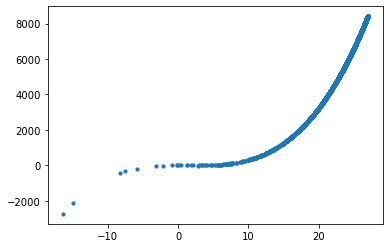

In [144]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 5000)**2 + 5**2
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 5000)
plt.scatter(x,y, s=10)
plt.show()

In [152]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

tree_reg_1 = DecisionTreeRegressor(max_depth=2)
tree_reg_1.fit([x],[y])
y_pred_1 = tree_reg_1.predict([x]) 
diff1 = y - y_pred_1
print(f"diff1 : {diff1}/n mse: {mean_squared_error([y] , y_pred_1)}")

diff1 : [[0. 0. 0. ... 0. 0. 0.]]/n mse: 0.0


Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [153]:
tree_reg_2 = DecisionTreeRegressor(max_depth=2)
tree_reg_2.fit([x],diff1)
y_pred_2 = tree_reg_2.predict([x])
diff2 = diff1 - y_pred_2 
print(f"diff2 : {diff2}/n mse: {mean_squared_error(diff1 , y_pred_2)}")

diff2 : [[0. 0. 0. ... 0. 0. 0.]]/n mse: 0.0


Then we train a third regressor on the residual errors made by the second predictor:

In [154]:
tree_reg_3 = DecisionTreeRegressor(max_depth=2)
tree_reg_3.fit([x],diff2)
y_pred_3 = tree_reg_3.predict([x])
diff3 = diff2 - y_pred_3 
print(f"diff2 : {diff3}/n mse: {mean_squared_error(diff2 , y_pred_3)}")

diff2 : [[0. 0. 0. ... 0. 0. 0.]]/n mse: 0.0


Now we have an ensemble containing thre trees. It can make predictions on a new instance simply by adding up the predicitons of all the trees:

In [155]:
y_pred = sum(tree.predict([x]) for tree in (tree_reg_1, tree_reg_2, tree_reg_3))
y_pred

array([[2147.4352092 , 7940.22427846, 5873.99188908, ..., 6103.48166194,
        8252.59289594, 7913.30338776]])

In [156]:
mean_squared_error([y], y_pred)

0.0

In [157]:
x[0], y[0]

(17.66435796205794, 2147.435209195856)

In [169]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(x.reshape(-1,1),y.reshape(-1,1))

C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [170]:
y_pred = gbrt.predict(x.reshape(-1,1))

In [171]:
mean_squared_error(y, y_pred)

164674.31697417638

In [172]:
X_train, X_val, y_train, y_val = train_test_split(x.reshape(-1,1), y.reshape(-1,1), test_size=0.2, random_state=42)

In [173]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [174]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]

In [176]:
bst_n_estimators = np.argmin(errors)
bst_n_estimators

119

In [177]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt.fit(X_train, y_train)

C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [178]:
mean_squared_error(y_val, gbrt.predict(X_val))

1114.630519763028

In [179]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

In [182]:
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break #early stopping

C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  ret

C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\student\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  ret

In [184]:
float("inf")

inf

In [2]:
!pip install xgboost

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\student\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\student\\AppData\\Local\\Temp\\pip-install-gpi0l_f1\\xgboost\\setup.py'"'"'; __file__='"'"'C:\\Users\\student\\AppData\\Local\\Temp\\pip-install-gpi0l_f1\\xgboost\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\student\AppData\Local\Temp\pip-wheel-5qjfiwxf'
       cwd: C:\Users\student\AppData\Local\Temp\pip-install-gpi0l_f1\xgboost\
  Complete output (775 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win32-3.8
  creating build\lib.win32-3.8\xgboost
  copying xgboost\callback.py -> build\lib.win32-3.8\xgboost
  copying xgboost\compat.py -> build\lib.win32-3.8\xgboost
  copying xgboost\config.py -> build\lib.win


  Running setup.py clean for xgboost
Failed to build xgboost
    Running setup.py install for xgboost: started
    Running setup.py install for xgboost: finished with status 'error'


    creating build\lib.win32-3.8\xgboost\plugin\lz4
    copying xgboost\plugin\lz4\sparse_page_lz4_format.cc -> build\lib.win32-3.8\xgboost\plugin\lz4
    creating build\lib.win32-3.8\xgboost\plugin\updater_gpu
    copying xgboost\plugin\updater_gpu\README.md -> build\lib.win32-3.8\xgboost\plugin\updater_gpu
    creating build\lib.win32-3.8\xgboost\plugin\updater_oneapi
    copying xgboost\plugin\updater_oneapi\README.md -> build\lib.win32-3.8\xgboost\plugin\updater_oneapi
    copying xgboost\plugin\updater_oneapi\predictor_oneapi.cc -> build\lib.win32-3.8\xgboost\plugin\updater_oneapi
    copying xgboost\plugin\updater_oneapi\regression_loss_oneapi.h -> build\lib.win32-3.8\xgboost\plugin\updater_oneapi
    copying xgboost\plugin\updater_oneapi\regression_obj_oneapi.cc -> build\lib.win32-3.8\xgboost\plugin\updater_oneapi
    creating build\lib.win32-3.8\xgboost\rabit
    copying xgboost\rabit\CMakeLists.txt -> build\lib.win32-3.8\xgboost\rabit
    creating build\lib.win32-3.8\xgboost\r

    creating build\temp.win32-3.8\Release\xgboost\dmlc-core\windows
    creating build\temp.win32-3.8\Release\xgboost\dmlc-core\windows\dmlc
    copying xgboost\dmlc-core\windows\dmlc\dmlc.vcxproj -> build\temp.win32-3.8\Release\xgboost\dmlc-core\windows\dmlc
    copying xgboost\dmlc-core\windows\dmlc.sln -> build\temp.win32-3.8\Release\xgboost\dmlc-core\windows
    creating build\temp.win32-3.8\Release\xgboost\rabit
    copying xgboost\rabit\CMakeLists.txt -> build\temp.win32-3.8\Release\xgboost\rabit
    creating build\temp.win32-3.8\Release\xgboost\rabit\include
    creating build\temp.win32-3.8\Release\xgboost\rabit\include\rabit
    copying xgboost\rabit\include\rabit\base.h -> build\temp.win32-3.8\Release\xgboost\rabit\include\rabit
    copying xgboost\rabit\include\rabit\c_api.h -> build\temp.win32-3.8\Release\xgboost\rabit\include\rabit
    creating build\temp.win32-3.8\Release\xgboost\rabit\include\rabit\internal
    copying xgboost\rabit\include\rabit\internal\engine.h -> bui

In [1]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

ModuleNotFoundError: No module named 'xgboost'